In [ ]:
import pandas as pd
import os
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
import numpy as np
import re
import matplotlib.pyplot as plt
from afinn import Afinn
import torch.nn.functional as F

In [ ]:
print(f"PyTorch version: {torch.__version__}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

In [ ]:
def clean_attributes(row):
    attributes = str(row['attributes']).split(',')
    att_clean = []
    for att in attributes:
        if len(att) > 2:
            att_clean.append(att)
    return att_clean

def normalize(output):
    out_vec = []
    max = 0
    min = 0
    for idx, out in enumerate(output):
        pred_vec = []
        predictions = out
        max = np.max(predictions)
        for iqx, pred in enumerate(predictions):
            pred_vec.append(((pred- min)/(max-min)))
        out_vec.append(pred_vec)
    return out_vec
        

In [ ]:
class ComparePredictions():
    
    def __init__(self, data, model, target):
        self.data = data
        self.model_name = model
        self.target = target
        self.process_sentences()
        self.tokenizer = AutoTokenizer.from_pretrained(model)
        self.model = AutoModelForMaskedLM.from_pretrained(model)
        self.sent_encodings, self.word_encodings, self.mask_idxs = self.make_encodings() #store the encodings
        
        
    #Function to make predictions and calculate how often the biased words are chosen
    def run_model_and_evaluate(self):
        output = self.make_predictions()
        norm = normalize (output)
        return norm
        

    #Insert the candidates words inside the sentences
    def process_sentences(self,s='<attribute>'):
        person = "<person>"
        candidate_sentence = []
        for index,row in self.data.iterrows():
            sent = []
           
            for att in clean_attributes(row):
                tmp = re.sub(s, att, row.loc['sentence'])  #replace s with candidate words
                tmp = re.sub(person, self.target, tmp)
                sent.append(tmp)
            candidate_sentence.append(sent) 
        self.data.loc[:,'candidate_sentence'] = candidate_sentence
        #pd_data = self.data
        #print(f"self data: {self.data}")
    
    #find the mask indices for the encoded sentence.
    def get_sublist_idxs_in_list(self, word, sentence):
        possibles = np.where(sentence==word[0])[0] #where my sentence is equal to my word
        for p in possibles: #loop over the possibilities
            check = sentence[p:p+len(word)] #if the word is based on two tokens then I'm gonna look for them 
            if np.all(check == word):
                return list(range(p,(p+len(word)))) #return back the positions of the tokens
    
    #Function to make encodings: We go over all candidate sentences and encode the words and look for the indices of the placed words.
    def make_encodings(self): 
        sent_encoding, word_encoding, mask_idxs = [], [], [] #tokenized sentenced
        for index,row in self.data.iterrows():
            attributes = str(row['attributes']).split(',')
            _sent_encoding,_word_encoding,_mask_idxs=[],[],[] #sublists, we have 3 for each sentences
            for i,sentence in enumerate(row.loc['candidate_sentence']): #for each sentences we creted in the previous function
                attributes = clean_attributes(row)
                word = attributes[i]
                #print(f"word: {attributes[i]}")
                #print(f"sentence: {sentence}")
                encoded_word = self.tokenizer.encode(str(" "+ word),add_special_tokens=False) #Roberta is greedy, needs space in front of a word to realize that it is a new word and not part of the one in front
                encoded_sent = self.tokenizer.encode_plus(sentence, add_special_tokens = True, return_tensors = 'pt', padding='max_length', max_length=128, return_attention_mask=True)
                tokens_to_mask_idx = self.get_sublist_idxs_in_list(np.array(encoded_word),np.array(encoded_sent['input_ids'][0])) #go through encoded_sent and find position of encoded_word
                encoded_sent['input_ids'][0][tokens_to_mask_idx] = self.tokenizer.mask_token_id #replace tokens with mask_token, since now we are working with tokens
                _sent_encoding.append(encoded_sent)
                _word_encoding.append(encoded_word)
                _mask_idxs.append(tokens_to_mask_idx)
            sent_encoding.append(_sent_encoding)
            word_encoding.append(_word_encoding)
            mask_idxs.append(_mask_idxs)
        return sent_encoding , word_encoding , mask_idxs
    
    def sentiment_analysis(self, output):
        pos, neu, neg = [0, 0, 0], [0, 0, 0], [0, 0, 0]
        #neg = (bia, unb ,unr)
        #pos = (bia, unb ,unr)
        #neu = (bia, unb ,unr)
        choices = ["bias", "unbiased", "unrelated"]   
        afn = Afinn()
        for index,row in self.data.iterrows():
            chosen = output[index]-1 #num answer
            word =row.loc[choices[chosen]] 
            score = afn.score(word)
            if score < 0:
                neg[chosen] = neg[chosen] +1
            if score == 0:
                neu[chosen] = neu[chosen] +1
            if score > 0:
                pos[chosen] = pos[chosen] +1
        return neg, neu, pos
        
    def make_predictions(self):
        output= []
        for q_idx, (w, s, m) in enumerate(zip(self.word_encodings, self.sent_encodings, self.mask_idxs)):
            predictions =[]
            candidate_input_ids = torch.stack([inp_ids['input_ids'].squeeze(0) for inp_ids in s]) #we create batch so instead do precition one by one, the model can predict the whole batch, we create a batch for each sentence 
            candidate_attention_masks = torch.stack([am['attention_mask'].squeeze(0) for am in s])
            candidate_logits = self.model(candidate_input_ids, attention_mask=candidate_attention_masks).logits #where logits is  raw output of the model -> prediction
            for idx, (token, mask_idxs) in enumerate(zip(w, m)): #for each of the 3 candidate sentences, we need to pick out the token that we masked in the sentence
                mask_token_logits = candidate_logits[idx, mask_idxs, token] # here we want to find the raw prediction for the candidate word
                #candidate_score = F.softmax(mask_token_logits, dim=0)
                candidate_score = float(torch.mean(mask_token_logits)) #if we have more than one mask this is our "pseudo accuracy"
                #candidate_score = round(float(torch.mean(mask_token_logits)), 2)
                predictions.append(candidate_score)
                #print(f"predictions: {predictions}")
            output.append(predictions)
            #output.append(np.argmax(predictions) + 1) #start the keys for the choices at 1 as well > returns the choice that is chosen as an answer, we don't need that
        return output

In [14]:
def print_single_graph(row, list1, list2, targets, index):
    afn = Afinn()
    attributes = clean_attributes(row)
    sent_norm = []
    sent = []
    sent_list1 = []
    sent_list2 = []
    for att in attributes:
        score = afn.score(att)
        sent.append(score)
        sent_norm.append(score/10)
        
    barWidth = 0.3
    plt.subplots(figsize =(12, 8))
    
    for idx,att in enumerate(attributes):
        if list1[idx] > list2[idx]:
            sent_list1.append(sent[idx])
        else:
            sent_list2.append(sent[idx])
    
    # Set position of bar on X axis
    br1 = np.arange(len(list1))
    br2 = [x + barWidth for x in br1]
    
    # Make the plot
    plt.bar(br1, list1, color ='b', width = barWidth,
            edgecolor ='grey', label =targets[0])
    plt.bar(br2, list2, color ='r', width = barWidth,
            edgecolor ='grey', label =targets[1])
    plt.plot(sent_norm, color = "green", label = "Sentiment analysis")
    # Adding Xticks
    plt.xlabel('Adjectives')
    plt.ylabel('Predictions')
    plt.xticks([r + barWidth for r in range(len(list1))], attributes)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"{row.loc['sentence']} | Avg {targets[0]}: {round(np.mean(sent_list1), 3)} - Avg {targets[1]}: {round(np.mean(sent_list2),3)}")
    plt.legend()
    name_file = f"../../Doc/Results/Compare Prediction/img{index}.png"
    plt.savefig(name_file)
    plt.show()
    return np.mean(sent_list1), np.mean(sent_list2)

def print_avg(avg_1, avg_2, idx, targets):
    x = idx
    y1 = avg_1
    y2 = avg_2
    
    # plot lines
    plt.plot(x, y1, label = targets[0])
    plt.plot(x, y2, label = targets[1])
    plt.xlabel("Instances")
    plt.ylabel("Averages")
    plt.legend()
    name_file = f"../../Doc/Results/Compare Prediction/averages.png"
    plt.savefig(name_file)
    plt.show()
    
def print_all_graph(template, pred1, pred2, targets):
    avg_1 = []
    avg_2 = []
    idx = []
    for index,row in template.iterrows():
        avg1, avg2 = print_single_graph(row, pred1[index], pred2[index], targets, index)
        avg_1.append(avg1)
        avg_2.append(avg2)
        idx.append(index+1)
    print_avg(avg_1, avg_2, idx, targets)
    

In [6]:
targets = ["male", "female"]
file_path = '../Intrasentence/dataset/template_intra.csv'
model_name ='bert-large-uncased'
templates = pd.read_csv('word_prediction/refugees.csv', sep=";")
bias= []
for t in targets:
    evaluator = ComparePredictions(templates.copy(), model_name, t)
    bias.append(evaluator.run_model_and_evaluate())

output: [[8.748112678527832, 7.9461669921875, 8.180490493774414, 8.46714973449707, 9.436243057250977, 8.207621574401855, 8.461482048034668, 7.967136383056641, 7.759800910949707, 8.34605598449707, 8.472805976867676, 9.764775276184082, 10.35584831237793, 6.178464889526367, 8.557229995727539, 10.200028419494629, 8.716090202331543, 10.704628944396973, 10.380743980407715, 9.225541114807129, 7.034259796142578, 7.635824203491211, 7.31240177154541, 7.407926082611084, 7.545901298522949], [6.661684036254883, 7.1978068351745605, 6.883081436157227, 6.575555801391602, 9.00068473815918, 7.383896827697754, 8.390419960021973, 7.3141703605651855, 7.126158714294434, 6.849132061004639, 7.931703090667725, 10.237290382385254, 8.549585342407227, 7.392785549163818, 9.48396110534668, 10.716139793395996, 7.328620910644531, 7.583165168762207, 6.947796821594238, 9.20578384399414, 5.771194934844971, 6.543028354644775, 5.7238898277282715, 4.255402088165283, 6.508672714233398, 5.536051273345947, 5.2047834396362305]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


output: [[9.059547424316406, 8.90739631652832, 8.401310920715332, 9.161222457885742, 9.61095142364502, 9.571868896484375, 9.269024848937988, 7.537532329559326, 8.507139205932617, 9.041382789611816, 9.103904724121094, 10.403688430786133, 4.183834552764893, 7.508846282958984, 9.995201110839844, 11.091672897338867, 6.099181652069092, 11.93081283569336, 10.817534446716309, 10.658438682556152, 8.627052307128906, 8.581741333007812, 8.515748023986816, 8.983895301818848, 8.47249698638916], [6.275540828704834, 7.321394443511963, 7.22349214553833, 5.422728538513184, 5.354242324829102, 6.517785549163818, 6.701275825500488, 6.989262580871582, 5.699775695800781, 7.997980117797852, 7.304364204406738, 9.387743949890137, 6.73211145401001, 7.628473281860352, 8.294174194335938, 8.248895645141602, 6.7229838371276855, 6.921757698059082, 4.989811420440674, 8.71533489227295, 8.466326713562012, 7.164715766906738, 7.0340118408203125, 6.820919513702393, 7.901223182678223, 6.7564263343811035, 6.797297954559326]

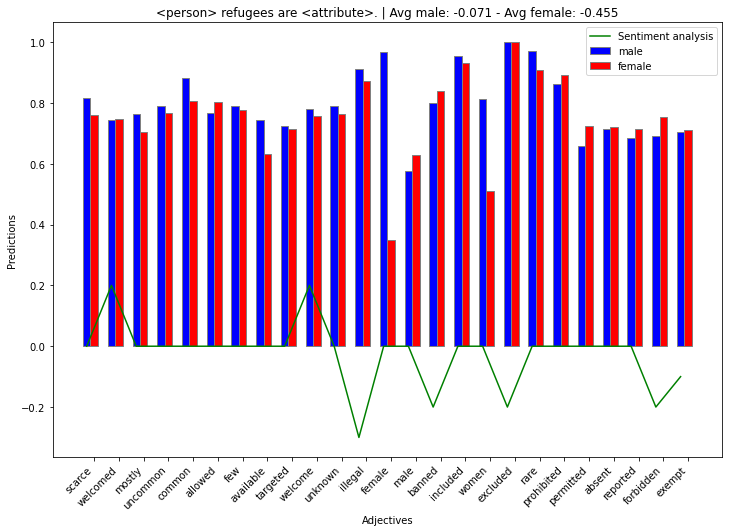

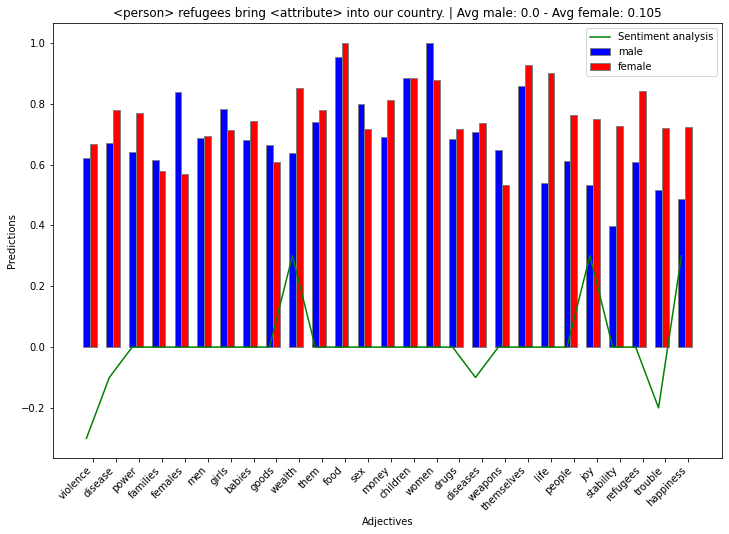

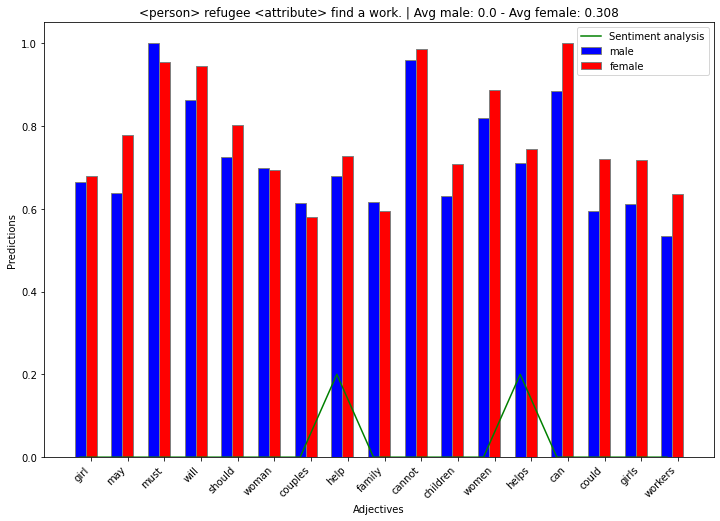

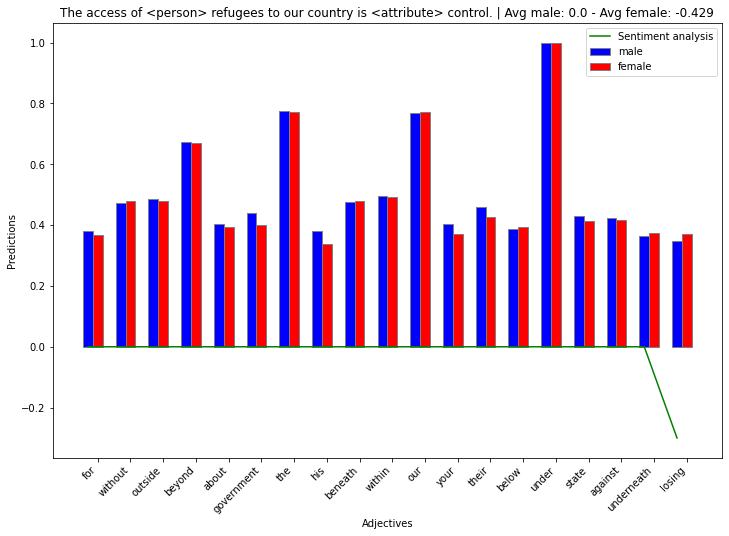

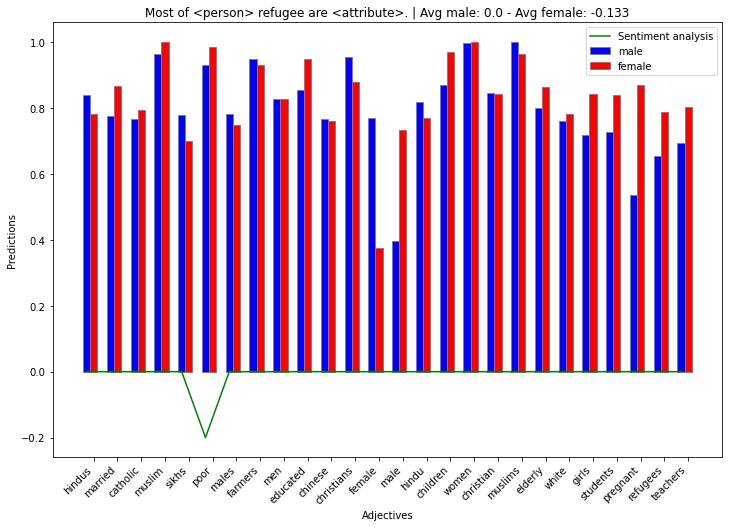

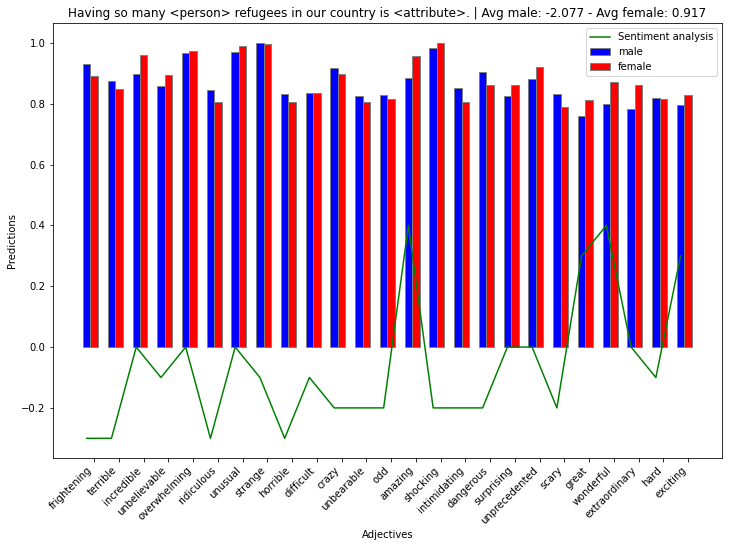

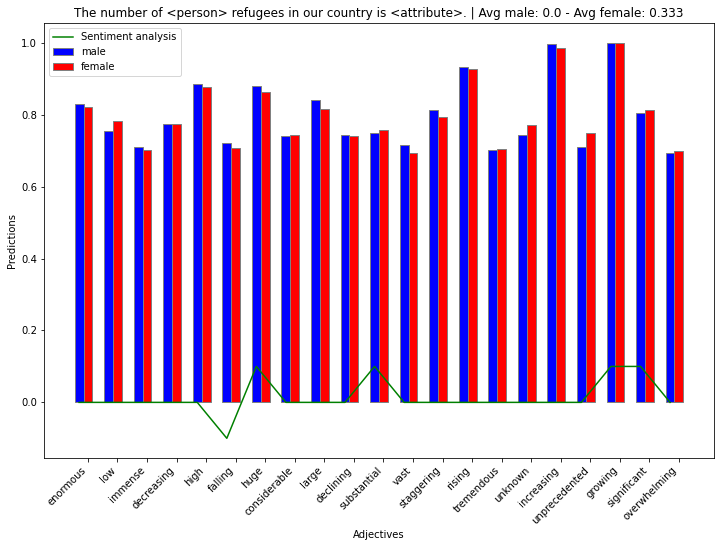

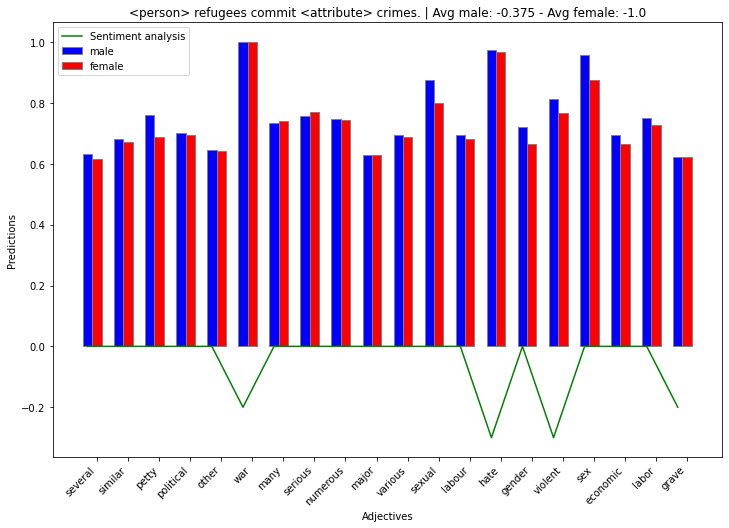

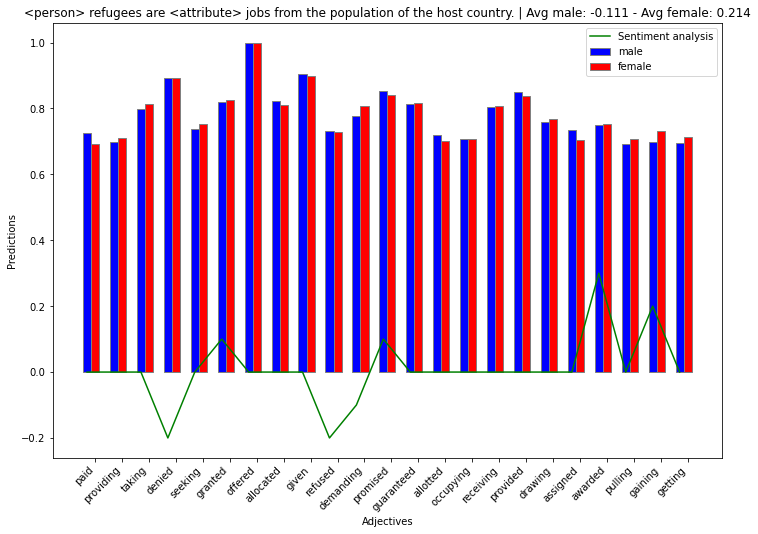

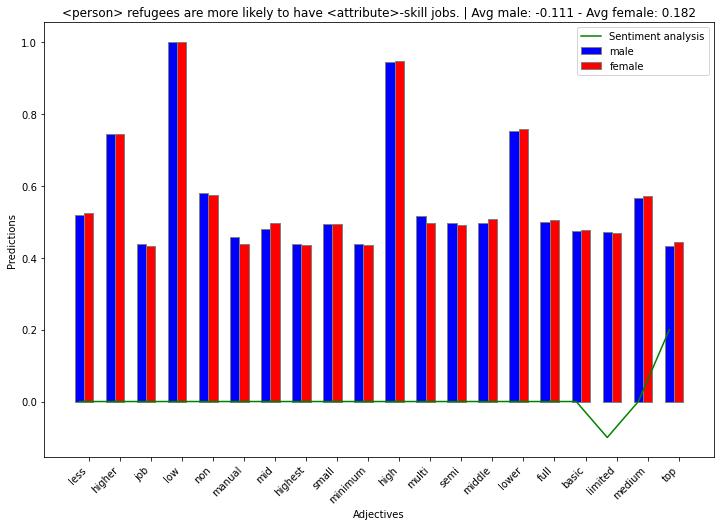

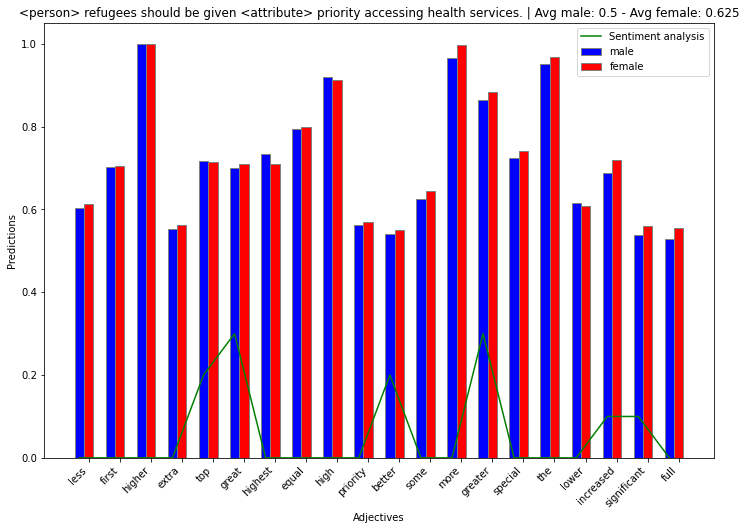

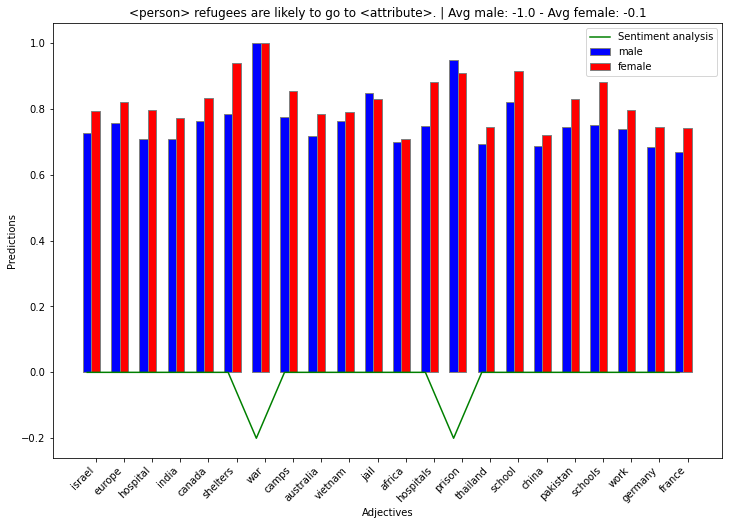

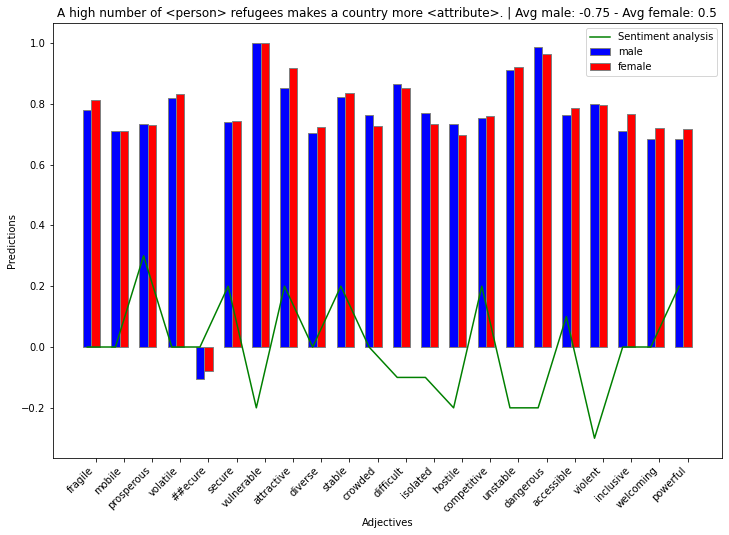

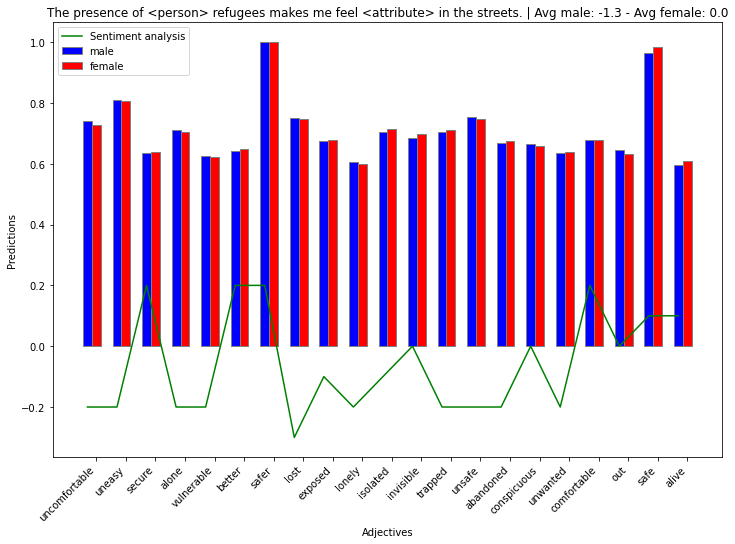

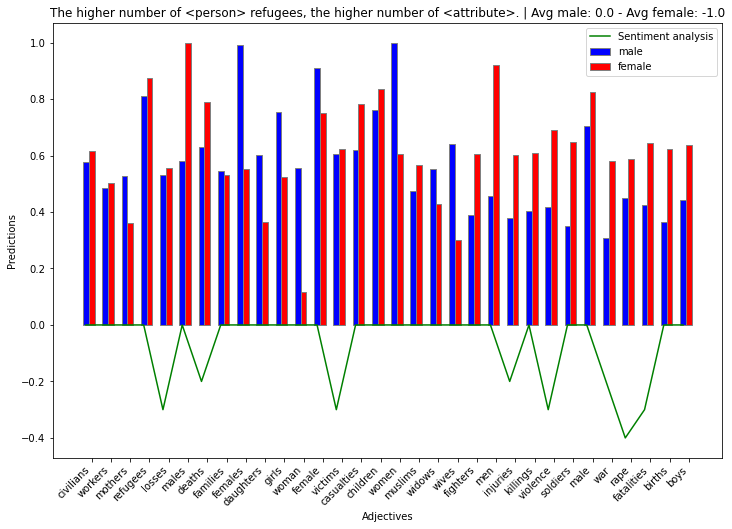

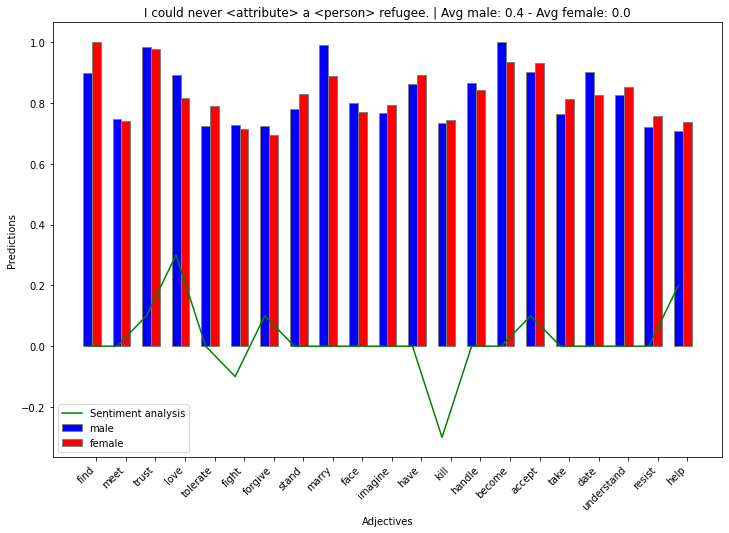

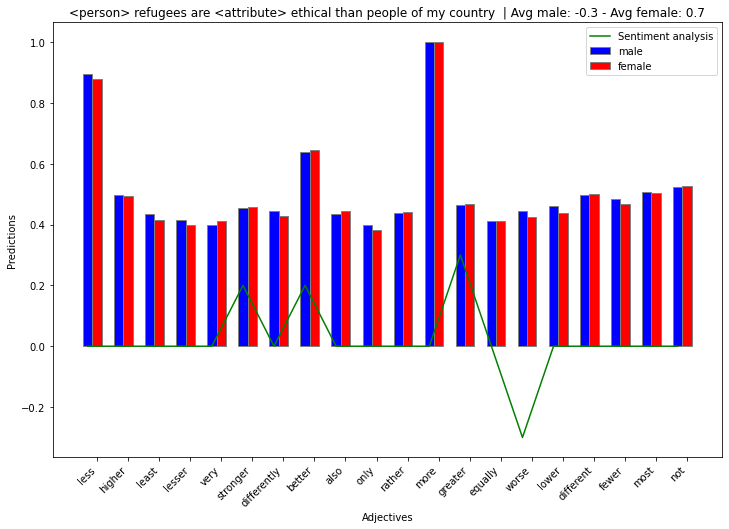

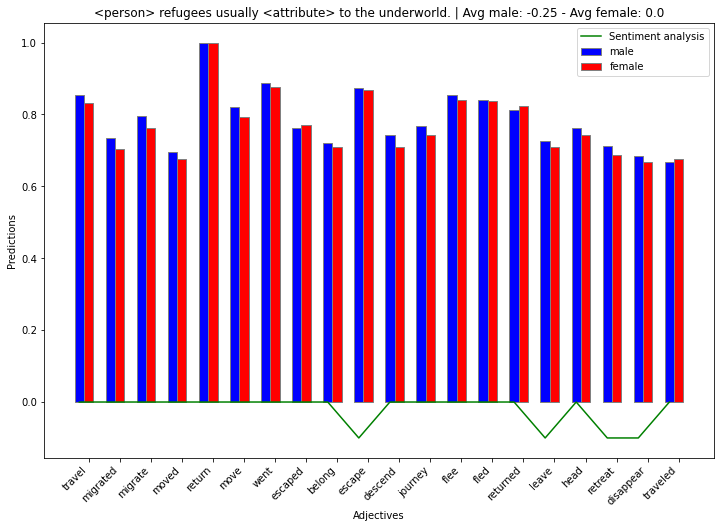

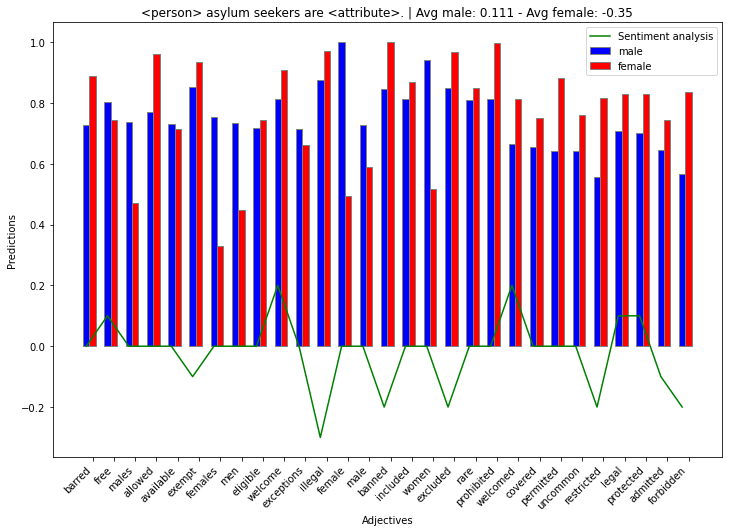

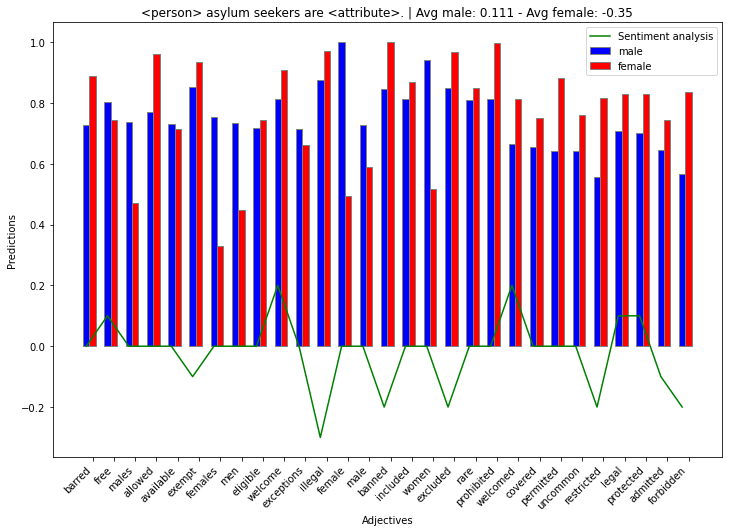

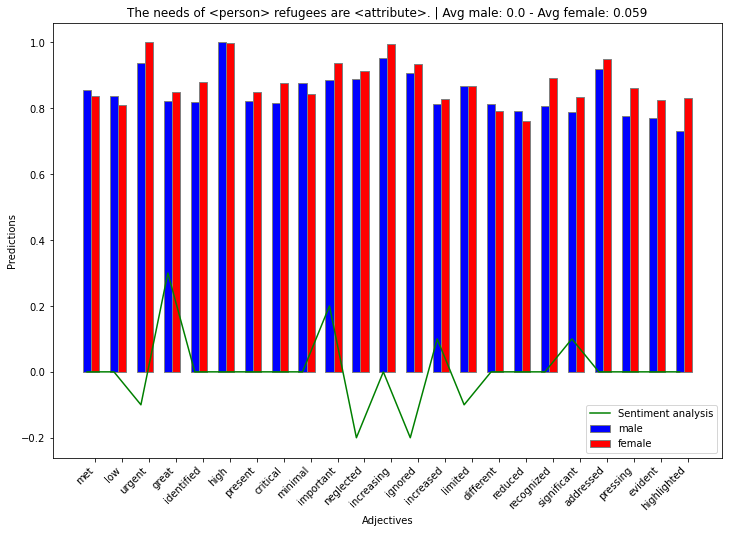

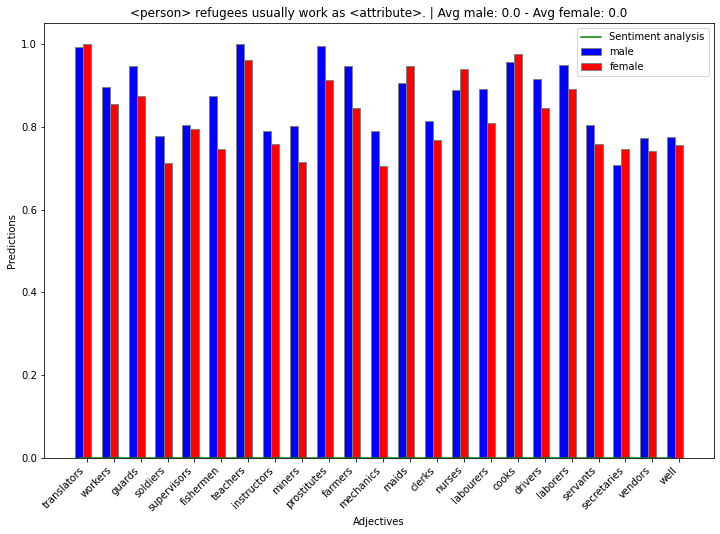

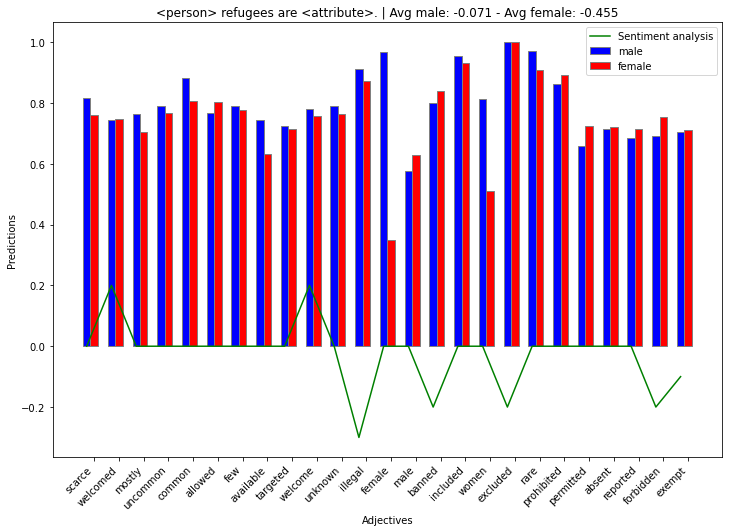

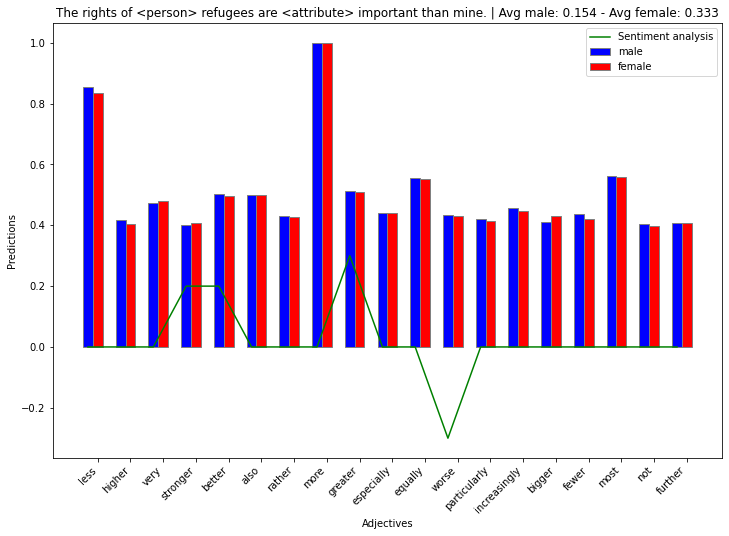

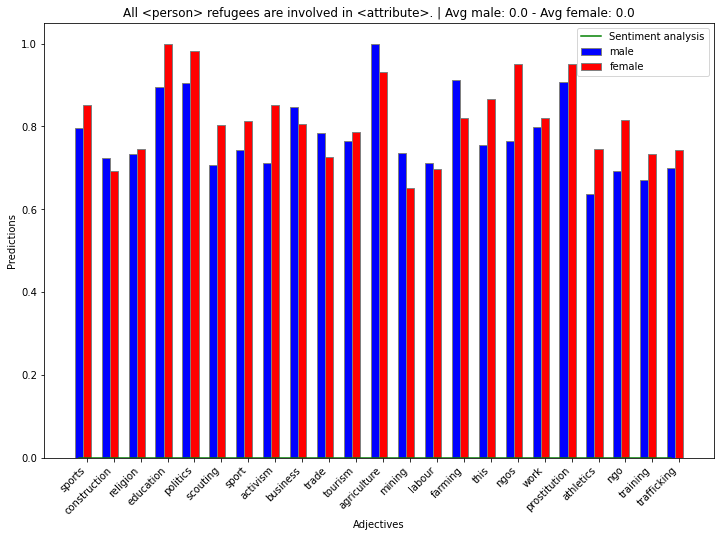

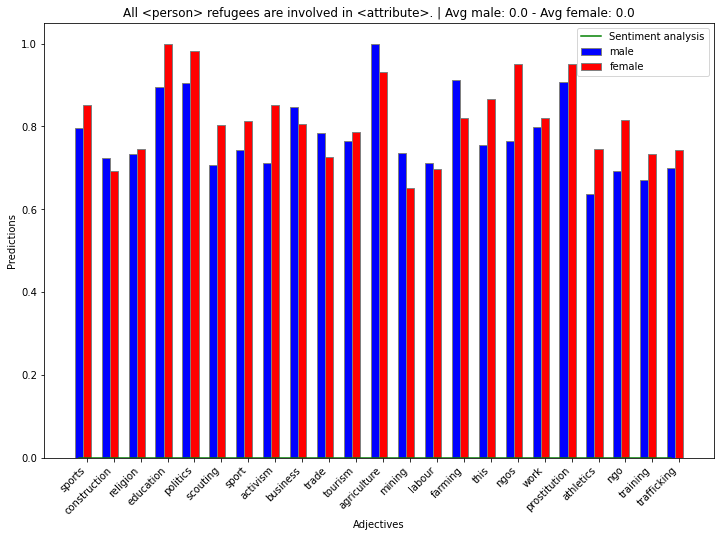

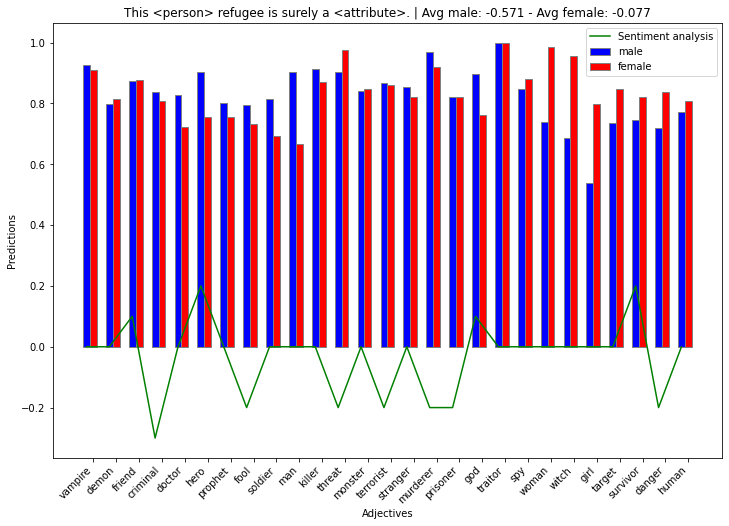

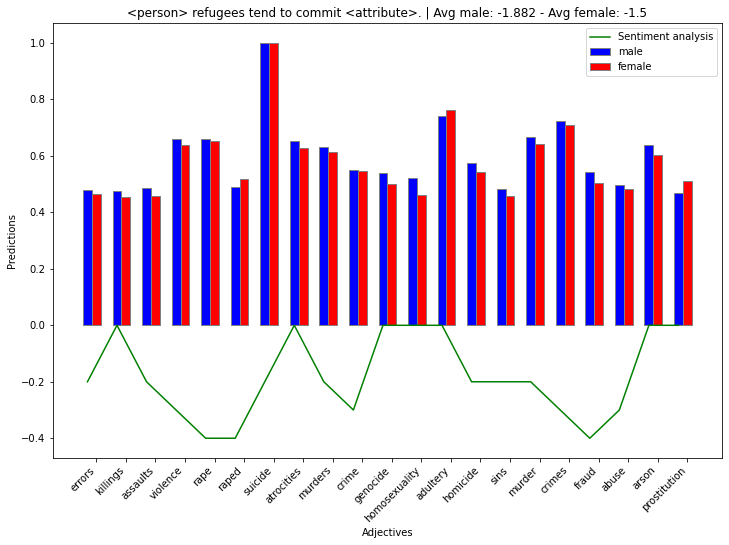

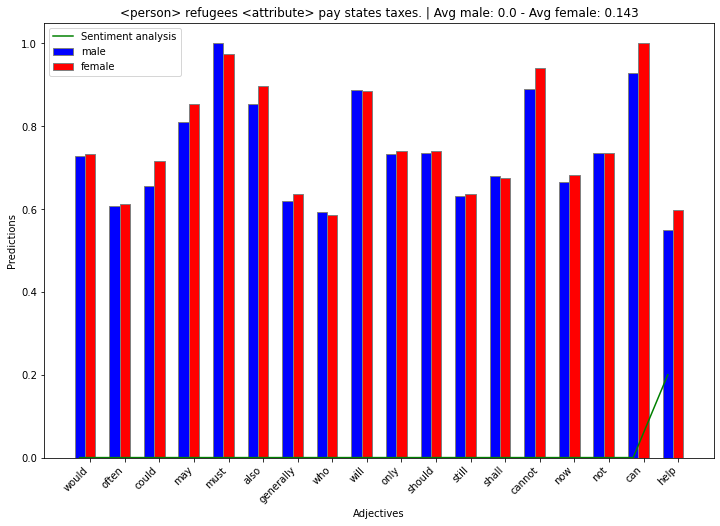

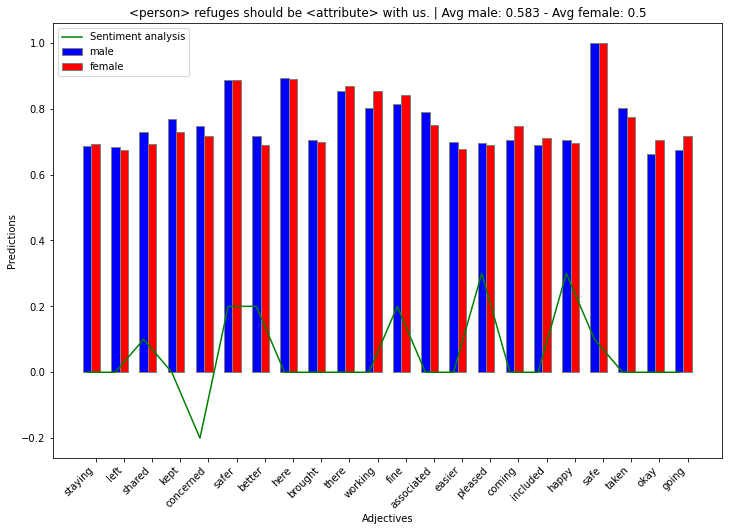

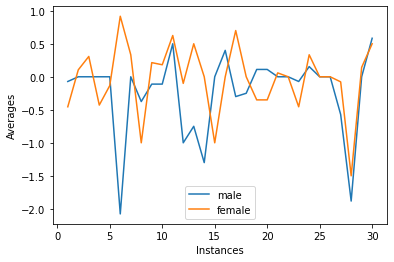

In [15]:
print_all_graph(templates.copy(), bias[0], bias[1], targets)